In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import datetime
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from get_decision_variable_map import get_decision_variable_map
from get_case_outputs_all_models import get_case_outputs_all_models
from get_unique_resources_data import get_unique_resources_data
from get_printable_resource_names import get_printable_resource_names

In [2]:
import os

current_dir = os.getcwd()
print(current_dir)

c:\Users\ks885\Documents\aa_research\Modeling\spcm_genx_experiment\figures


In [3]:
plots_path = os.path.join(current_dir, 'plots') + "/"
pdf_path = os.path.join(current_dir, 'pdf_tables') + "/"
latex_path = os.path.join(current_dir, 'latex') + "/"
csv_path = os.path.join(current_dir, 'csv') + "/"
jpg_path = os.path.join(current_dir, 'jpg') + "/"
veps_path = os.path.join(current_dir, 'veps') + "/"

In [4]:
price_band_path = os.path.join(veps_path, 'price_band') + "/"
if not os.path.exists(price_band_path):
    os.makedirs(price_band_path)

In [5]:
# modeling scaling ModelScalingFactor
ModelScalingFactor = 1000

cem_path = os.path.join(os.path.dirname(current_dir), 'GenX.jl', 'research_systems')
policies_path = os.path.join(os.path.dirname(current_dir), 'SPCM', 'research_systems')

date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [6]:
case_names = [    
              "Thermal_Base",
              "2_Hr_BESS", 
              "2_Hr_BESS_Fuelx2",
              "4_Hr_BESS",
              "4_Hr_BESS_Fuelx2",
              "4_Hr_BESS_Fuelx3",
              "4_Hr_BESS_Fuelx4",
              "6_Hr_BESS",
              "6_Hr_BESS_Fuelx2",
              "8_Hr_BESS",
              "8_Hr_BESS_Fuelx2",
              "10_Hr_BESS",
              "10_Hr_BESS_Fuelx2",
              ]

policy_types = [
                'pf',
                'dlac-p',
                'dlac-i',
                'slac',
]

# Create a DataFrame with decision_variable_names as the index
decision_variable_map = get_decision_variable_map()

In [7]:
unique_resources, cases_resources_capacities = get_unique_resources_data(case_names, policies_path)


adding resource: NG 2-on-1 Combined Cycle (F-Frame) from case: Thermal_Base
adding resource: NG Combustion Turbine (F-Frame) from case: Thermal_Base
adding resource: Land-Based Wind - Class 1 - Technology 1 from case: Thermal_Base
adding resource: Utility PV - Class 1 from case: Thermal_Base
adding resource: Utility-Scale Battery Storage - 2Hr from case: 2_Hr_BESS
adding resource: Utility-Scale Battery Storage - 4Hr from case: 4_Hr_BESS
adding resource: Utility-Scale Battery Storage - 6Hr from case: 6_Hr_BESS
adding resource: Utility-Scale Battery Storage - 8Hr from case: 8_Hr_BESS
adding resource: Utility-Scale Battery Storage - 10Hr from case: 10_Hr_BESS


In [8]:
print_unique_resources = get_printable_resource_names(unique_resources)

In [9]:
print_unique_resources

['NG CC', 'NG CT', 'Wind', 'Solar', 'BESS']

In [10]:
# intialize dictionary for saving results for each case
revenue_by_price_dict = {case: {resource: {} for resource in print_unique_resources} for case in case_names}
generation_by_price_dict = {case: {resource: {} for resource in print_unique_resources} for case in case_names}


In [11]:
revenue_by_price_dict['Thermal_Base']

{'NG CC': {}, 'NG CT': {}, 'Wind': {}, 'Solar': {}, 'BESS': {}}

In [12]:
def plot_selected_cases_normalized_feature_by_price_band(selected_cases, data, save_path, feature_str, resource_order=None):
    # Define price bands and colors
    price_bands = [(0, 5), (5, 50), (50, 200), (200, 1000), (1000, 5001)]
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0']

    # Collect handles and labels for a single set of price bands
    legend_handles = []
    legend_labels = []

    # Get a dictionary with only the selected cases
    selected_data = {case: data[case] for case in selected_cases if case in data}

    # Setup the figure and axes
    fig, axes = plt.subplots(len(selected_data), 1, figsize=(12, 8), sharex=True)

    if len(selected_data) == 1:
        axes = [axes]

    # Plot data for each case
    for i, (ax, (case, resources)) in enumerate(zip(axes, selected_data.items())):
        # Determine resource names order
        if resource_order is not None:
            resource_names = [r for r in resource_order if r in resources]
        else:
            resource_names = list(resources.keys())
        bar_width = 0.2
        x = np.arange(len(resource_names)) * (1 + bar_width)  # Add gap between resources

        # Initialize offsets for each model
        model_names = resources[resource_names[0]].columns
        offsets = np.arange(len(model_names)) * bar_width

        # Loop through each model
        for offset, model in zip(offsets, model_names):
            # Prepare stack heights for the model
            bottom_stack = np.zeros(len(resource_names))

            # Plot each price band
            for price_band, color in zip(price_bands, colors):
                heights = [
                    resources[resource].at[price_band, model] if price_band in resources[resource].index else 0
                    for resource in resource_names
                ]
                bars = ax.bar(
                    x + offset,
                    heights,
                    bar_width,
                    bottom=bottom_stack,
                    color=color,
                    edgecolor='black'
                )
                bottom_stack += heights

                # Add one handle per price band to the legend (only once)
                if price_band not in legend_labels:
                    legend_handles.append(bars[0])
                    legend_labels.append(price_band)

        offset_epsilon = 0.001  # Small offset to prevent exact overlap
        # Set the main ticks for resources
        adjusted_x_positions = [
            pos + (-offset_epsilon if i % len(model_names) < len(model_names) // 2 else offset_epsilon)
            for i, pos in enumerate(x + bar_width * (len(model_names) / 2 - 0.5))
        ]
        ax.set_xticks(adjusted_x_positions)
        ax.set_xticklabels(resource_names, fontsize=12, weight='bold')

        # Remove the major ticks while keeping the labels
        ax.tick_params(axis='x', which='major', bottom=False)

        # Add sub-tick labels to the top plot and bottom plot
        if i == len(axes) - 1:  # For bottommost subplots
            model_tick_positions = [
                x_val + offset for x_val in x for offset in offsets
            ]
            model_tick_labels = [model for _ in x for model in model_names]
            ax.set_xticks(model_tick_positions, minor=True)
            ax.set_xticklabels(model_tick_labels, minor=True, rotation=45, fontsize=9)

            # Adjust sub-tick spacing
            ax.tick_params(axis='x', which='minor', bottom=True, top=False, length=5, pad=10)

        # Ensure the resource labels (major ticks) don't overlap
        ax.tick_params(axis='x', which='major', pad=50)  # Push resource labels further from sub-ticks

        # Add grid lines
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Set title
        print_case_name = case.replace('_', ' ')
        ax.set_title(print_case_name)

    # Add the legend to the top plot
    top_ax = axes[0]
    legend = top_ax.legend(
        legend_handles, 
        [str(band) for band in legend_labels], 
        loc="upper left", 
        bbox_to_anchor=(1.05, 1), 
        title="Price Band ($/MWh)",
        frameon=True
    )

    # Style the legend
    legend.get_title().set_fontsize('12')
    legend.get_title().set_weight('bold')
    legend.set_bbox_to_anchor((1.0, 1.0))  # Align legend inside the plot
    legend._legend_box.align = "left"  # Arrange labels vertically

    # Add a single y-axis label for the entire figure
    fig.text(0.04, 0.5, f'{feature_str} by Electricity Price (%)', va='center', rotation='vertical', fontsize=14, weight='bold')

    # Adjust layout
    plt.tight_layout(rect=[0.05, 0.05, 1, 1])

    str_selected_cases = "_".join(selected_cases)

    # Save to jpg
    plt.savefig(os.path.join(save_path, f'{feature_str}_by_price_{str_selected_cases}.eps'),format='eps', dpi=300, bbox_inches='tight')
    plt.show()


In [13]:
# def plot_selected_cases_revenue_by_price(selected_cases, data, save_path):
#     # Define price bands and colors
#     price_bands = [(0, 5), (5, 50), (50, 200), (200, 1000), (1000, 5001)]
#     colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0']

#     # Collect handles and labels for a single set of price bands
#     legend_handles = []
#     legend_labels = []

#     # Get a dictionary with only the selected cases
#     selected_data = {case: data[case] for case in selected_cases if case in data}

#     # Setup the figure and axes
#     fig, axes = plt.subplots(len(selected_data), 1, figsize=(12, 8), sharex=True)

#     if len(selected_data) == 1:
#         axes = [axes]

#     # Plot data for each case
#     for i, (ax, (case, resources)) in enumerate(zip(axes, selected_data.items())):
#         # print(f"Plotting case: {case}", ' i: ', i)
#         resource_names = list(resources.keys())
#         bar_width = 0.2
#         x = np.arange(len(resource_names)) * (1 + bar_width)  # Add gap between resources
#         # print(f"x: {x}")


#         # Initialize offsets for each model
#         model_names = resources[resource_names[0]].columns
#         offsets = np.arange(len(model_names)) * bar_width
#         # print(f"offsets: {offsets}")

#         # Loop through each model
#         for offset, model in zip(offsets, model_names):
#             # Prepare stack heights for the model
#             bottom_stack = np.zeros(len(resource_names))

#             # Plot each price band
#             for price_band, color in zip(price_bands, colors):
#                 heights = [
#                     resources[resource].at[price_band, model] if price_band in resources[resource].index else 0
#                     for resource in resource_names
#                 ]
#                 bars = ax.bar(
#                     x + offset,
#                     heights,
#                     bar_width,
#                     bottom=bottom_stack,
#                     color=color,
#                     edgecolor='black'
#                 )
#                 bottom_stack += heights

#                 # Add one handle per price band to the legend (only once)
#                 if price_band not in legend_labels:
#                     legend_handles.append(bars[0])
#                     legend_labels.append(price_band)

#         offset_epsilon = 0.001  # Small offset to prevent exact overlap
#         # Set the main ticks for resources
#         adjusted_x_positions = [
#             pos + (-offset_epsilon if i % len(model_names) < len(model_names) // 2 else offset_epsilon)
#             for i, pos in enumerate(x + bar_width * (len(model_names) / 2 - 0.5))
#         ]
#         ax.set_xticks(adjusted_x_positions)
#         ax.set_xticklabels(resource_names, fontsize=12, weight='bold')

#         # Remove the major ticks while keeping the labels
#         ax.tick_params(axis='x', which='major', bottom=False)

#         # Add sub-tick labels to the top plot and bottom plot
#         if i == len(axes) - 1:  # For bottommost subplots
#             model_tick_positions = [
#             x_val + offset for x_val in x for offset in offsets
#             ]
#             model_tick_labels = [model for _ in x for model in model_names]
#             ax.set_xticks(model_tick_positions, minor=True)
#             ax.set_xticklabels(model_tick_labels, minor=True, rotation=45, fontsize=9)

#             # Adjust sub-tick spacing
#             ax.tick_params(axis='x', which='minor', bottom=True, top=False, length=5, pad=10)

#         # Ensure the resource labels (major ticks) don't overlap
#         ax.tick_params(axis='x', which='major', pad=50)  # Push resource labels further from sub-ticks

#         # Add grid lines
#         ax.grid(axis='y', linestyle='--', alpha=0.7)

#         # Set title
#         print_case_name = case.replace('_', ' ')
#         ax.set_title(print_case_name)

#     # Add the legend to the top plot
#     top_ax = axes[0]
#     legend = top_ax.legend(
#         legend_handles, 
#         [str(band) for band in legend_labels], 
#         loc="upper left", 
#         bbox_to_anchor=(1.05, 1), 
#         title="Price Band ($/MWh)",
#         frameon=True
#     )

#     # Style the legend
#     legend.get_title().set_fontsize('12')
#     legend.get_title().set_weight('bold')
#     legend.set_bbox_to_anchor((1.0, 1.0))  # Align legend inside the plot
#     legend._legend_box.align = "left"  # Arrange labels vertically

#     # Add a single y-axis label for the entire figure
#     fig.text(0.04, 0.5, 'Revenue by Electricity Price (%)', va='center', rotation='vertical', fontsize=14, weight='bold')

#     # Adjust layout
#     plt.tight_layout(rect=[0.05, 0.05, 1, 1])

#     str_selected_cases = "_".join(selected_cases)

#     # Save to jpg
#     plt.savefig(os.path.join(save_path, f'revenue_by_price_{str_selected_cases}.jpg'), dpi=300, bbox_inches='tight')
#     plt.show()


In [14]:
for case_name in case_names:

    print('Case Name: ' + case_name + '\n')


    # load generator characteristics from resources folder
    thermal_dfGen = pd.read_csv(policies_path + '\\' + case_name + '\\resources' + '\\Thermal.csv')
    vre_dfGen = pd.read_csv(policies_path + '\\' + case_name + '\\resources' + '\\Vre.csv')
    storage_dfGen = pd.read_csv(policies_path + '\\' + case_name + '\\resources' + '\\Storage.csv')

    # combine all resources to dfGen
    dfGen = pd.concat([thermal_dfGen, vre_dfGen, storage_dfGen], ignore_index=True)


    cem_prices, policies_prices_dict, prices_cols = get_case_outputs_all_models(cem_path, 
        policies_path, case_name, 'energy prices', policy_types)
    
    cem_dispatch_unprint, policies_dispatch_dict_unprint, dispatch_cols = get_case_outputs_all_models(cem_path,
        policies_path, case_name, 'discharge', policy_types)
    
    cem_dispatch = get_printable_resource_names(cem_dispatch_unprint)
    policies_dispatch_dict = get_printable_resource_names(policies_dispatch_dict_unprint)
    
    pf_prices = policies_prices_dict['pf']
    dlac_prices = policies_prices_dict['dlac-p']
    dlac_imperfect_prices = policies_prices_dict['dlac-i']
    slac_prices = policies_prices_dict['slac']
    

    # set price bands
    first_lvl = 5
    second_lvl = 50
    third_lvl = 200
    fourth_lvl = 1000
    fifth_lvl = 5001
    price_bands = [(0, first_lvl), (first_lvl, second_lvl), (second_lvl, third_lvl), 
                (third_lvl, fourth_lvl), (fourth_lvl, fifth_lvl)]
    price_band_labels = ['0-5', '5-50', '50-200', '200-1000', '1000-5000']

    zone_name = prices_cols[0]

    # determine indices where prices are in the bands for each model
    cem_price_band_indices = {band: cem_prices[(cem_prices[zone_name] >= band[0]) 
                                                & (cem_prices[zone_name] < band[1])].index 
                                                for band in price_bands}
    
    pf_price_band_indices = {band: pf_prices[(pf_prices[zone_name] >= band[0])
                                                & (pf_prices[zone_name] < band[1])].index 
                                                for band in price_bands}
    
    dlac_price_band_indices = {band: dlac_prices[(dlac_prices[zone_name] >= band[0]) 
                                                    & (dlac_prices[zone_name] < band[1])].index 
                                                    for band in price_bands}
    
    dlac_imperfect_price_band_indices = {band: dlac_imperfect_prices[(dlac_imperfect_prices[zone_name] >= band[0]) 
                                                                        & (dlac_imperfect_prices[zone_name] < band[1])].index 
                                                                        for band in price_bands}
    
    slac_price_band_indices = {band: slac_prices[(slac_prices[zone_name] >= band[0]) 
                                                    & (slac_prices[zone_name] < band[1])].index 
                                                    for band in price_bands}
    
    resource_revenue_dict = {resource: {} for resource in print_unique_resources}

    generation_dict = {resource: {} for resource in print_unique_resources}

    for res in print_unique_resources:
        # print('Resource: ' + res + '\n')

        case_resources = list(dfGen['Resource'].unique())
        # print('case resources: ' + str(case_resources))
        print_case_resources = get_printable_resource_names(case_resources)
        # print('print case resources: ' + str(print_case_resources))

        # find resource that is in unique list but not case_resources
        addl_resource = [resource for resource in print_unique_resources if resource not in print_case_resources]
        # print('addl resource: ' + str(addl_resource))

        if res in addl_resource:
            empty_bands = {band: 0 for band in cem_price_band_indices.keys()}

            # initialize dictionary for resource specific results
            revenue_by_price_df = pd.DataFrame({'CEM': empty_bands,
                                                        'PF': empty_bands,
                                                        'DLAC-p': empty_bands,
                                                        'DLAC-i': empty_bands,
                                                        'SLAC': empty_bands})
            
            resource_revenue_dict[res] = revenue_by_price_df

            generation_df = pd.DataFrame({'CEM': empty_bands,
                                          'PF': empty_bands,
                                          'DLAC-p': empty_bands,
                                          'DLAC-i': empty_bands,
                                          'SLAC': empty_bands})
            generation_dict[res] = generation_df
        else:
            # find the index of the storage in the generator list

            cem_revenue_ts = cem_prices[zone_name] * cem_dispatch[res]
            pf_revenue_ts = pf_prices[zone_name] * policies_dispatch_dict['pf'][res]
            dlac_revenue_ts = dlac_prices[zone_name] * policies_dispatch_dict['dlac-p'][res]
            dlac_imperfect_revenue_ts = dlac_imperfect_prices[zone_name] * policies_dispatch_dict['dlac-i'][res]
            slac_revenue_ts = slac_prices[zone_name] * policies_dispatch_dict['slac'][res]

            # caluclate total energy revenues for resource
            cem_total_energy_revenue = cem_revenue_ts.sum()
            pf_total_energy_revenue = pf_revenue_ts.sum()
            dlac_total_energy_revenue = dlac_revenue_ts.sum()
            dlac_imperfect_total_energy_revenue = dlac_imperfect_revenue_ts.sum()
            slac_total_energy_revenue = slac_revenue_ts.sum()

            # normalize the revenues
            cem_revenue_ts_norm = cem_revenue_ts / cem_total_energy_revenue
            pf_revenue_ts_norm = pf_revenue_ts / pf_total_energy_revenue
            dlac_revenue_ts_norm = dlac_revenue_ts / dlac_total_energy_revenue
            dlac_imperfect_revenue_ts_norm = dlac_imperfect_revenue_ts / dlac_imperfect_total_energy_revenue
            slac_revenue_ts_norm = slac_revenue_ts / slac_total_energy_revenue

            # separate the normalized revenues into price bands based on indices
            cem_perc_rev_bands = {band: cem_revenue_ts_norm[indices] for band, indices in cem_price_band_indices.items()}
            pf_perc_rev_bands = {band: pf_revenue_ts_norm[indices] for band, indices in pf_price_band_indices.items()}
            dlac_perc_rev_bands = {band: dlac_revenue_ts_norm[indices] for band, indices in dlac_price_band_indices.items()}
            dlac_imperfect_perc_rev_bands = {band: dlac_imperfect_revenue_ts_norm[indices] 
                                                for band, indices in dlac_imperfect_price_band_indices.items()}
            slac_perc_rev_bands = {band: slac_revenue_ts_norm[indices] for band, indices in slac_price_band_indices.items()}

            # calculate the sum of the percentage of revenues in each price band
            cem_revenue_band_sums = {band: perc_rev.sum() for band, perc_rev in cem_perc_rev_bands.items()}
            pf_revenue_band_sums = {band: perc_rev.sum() for band, perc_rev in pf_perc_rev_bands.items()}
            dlac_revenue_band_sums = {band: perc_rev.sum() for band, perc_rev in dlac_perc_rev_bands.items()}
            dlac_imperfect_revenue_band_sums = {band: perc_rev.sum() 
                                                    for band, perc_rev in dlac_imperfect_perc_rev_bands.items()}
            slac_revenue_band_sums = {band: perc_rev.sum() for band, perc_rev in slac_perc_rev_bands.items()}

            # calculate total dispatch for each resource
            cem_total_dispatch = cem_dispatch[res].sum()
            pf_total_dispatch = policies_dispatch_dict['pf'][res].sum()
            dlac_total_dispatch = policies_dispatch_dict['dlac-p'][res].sum()
            dlac_imperfect_total_dispatch = policies_dispatch_dict['dlac-i'][res].sum()
            slac_total_dispatch = policies_dispatch_dict['slac'][res].sum()

            # normalize the dispatch timeseries
            cem_dispatch_norm = cem_dispatch[res] / cem_total_dispatch
            pf_dispatch_norm = policies_dispatch_dict['pf'][res] / pf_total_dispatch
            dlac_dispatch_norm = policies_dispatch_dict['dlac-p'][res] / dlac_total_dispatch
            dlac_imperfect_dispatch_norm = policies_dispatch_dict['dlac-i'][res] / dlac_imperfect_total_dispatch
            slac_dispatch_norm = policies_dispatch_dict['slac'][res] / slac_total_dispatch

            # separate the normalized dispatch into price bands based on indices
            cem_perc_dispatch_bands = {band: cem_dispatch_norm[indices] for band, indices in cem_price_band_indices.items()}
            pf_perc_dispatch_bands = {band: pf_dispatch_norm[indices] for band, indices in pf_price_band_indices.items()}
            dlac_perc_dispatch_bands = {band: dlac_dispatch_norm[indices] for band, indices in dlac_price_band_indices.items()}
            dlac_imperfect_perc_dispatch_bands = {band: dlac_imperfect_dispatch_norm[indices]
                                                    for band, indices in dlac_imperfect_price_band_indices.items()}
            slac_perc_dispatch_bands = {band: slac_dispatch_norm[indices] for band, indices in slac_price_band_indices.items()}

            # calculate the sum of the normalized dispatch in each price band
            cem_dispatch_band_sums = {band: perc_dispatch.sum() for band, perc_dispatch in cem_perc_dispatch_bands.items()}
            pf_dispatch_band_sums = {band: perc_dispatch.sum() for band, perc_dispatch in pf_perc_dispatch_bands.items()}
            dlac_dispatch_band_sums = {band: perc_dispatch.sum() for band, perc_dispatch in dlac_perc_dispatch_bands.items()}
            dlac_imperfect_dispatch_band_sums = {band: perc_dispatch.sum()
                                                    for band, perc_dispatch in dlac_imperfect_perc_dispatch_bands.items()}
            slac_dispatch_band_sums = {band: perc_dispatch.sum() for band, perc_dispatch in slac_perc_dispatch_bands.items()}

            # create a dataframe for the revenue by price band sums
            revenue_by_price_df = pd.DataFrame({'CEM': cem_revenue_band_sums,
                                                'PF': pf_revenue_band_sums,
                                                'DLAC-p': dlac_revenue_band_sums,
                                                'DLAC-i': dlac_imperfect_revenue_band_sums,
                                                'SLAC': slac_revenue_band_sums})
            
            generation_df = pd.DataFrame({'CEM': cem_dispatch_band_sums,
                                          'PF': pf_dispatch_band_sums,
                                          'DLAC-p': dlac_dispatch_band_sums,
                                          'DLAC-i': dlac_imperfect_dispatch_band_sums,
                                          'SLAC': slac_dispatch_band_sums})

            
            resource_revenue_dict[res] = revenue_by_price_df

            generation_dict[res] = generation_df


    revenue_by_price_dict[case_name] = resource_revenue_dict

    generation_by_price_dict[case_name] = generation_dict



# end of loop

        
    


    

Case Name: Thermal_Base

Case Name: 2_Hr_BESS

Case Name: 2_Hr_BESS_Fuelx2

Case Name: 4_Hr_BESS

Case Name: 4_Hr_BESS_Fuelx2

Case Name: 4_Hr_BESS_Fuelx3

Case Name: 4_Hr_BESS_Fuelx4

Case Name: 6_Hr_BESS

Case Name: 6_Hr_BESS_Fuelx2

Case Name: 8_Hr_BESS

Case Name: 8_Hr_BESS_Fuelx2

Case Name: 10_Hr_BESS

Case Name: 10_Hr_BESS_Fuelx2



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


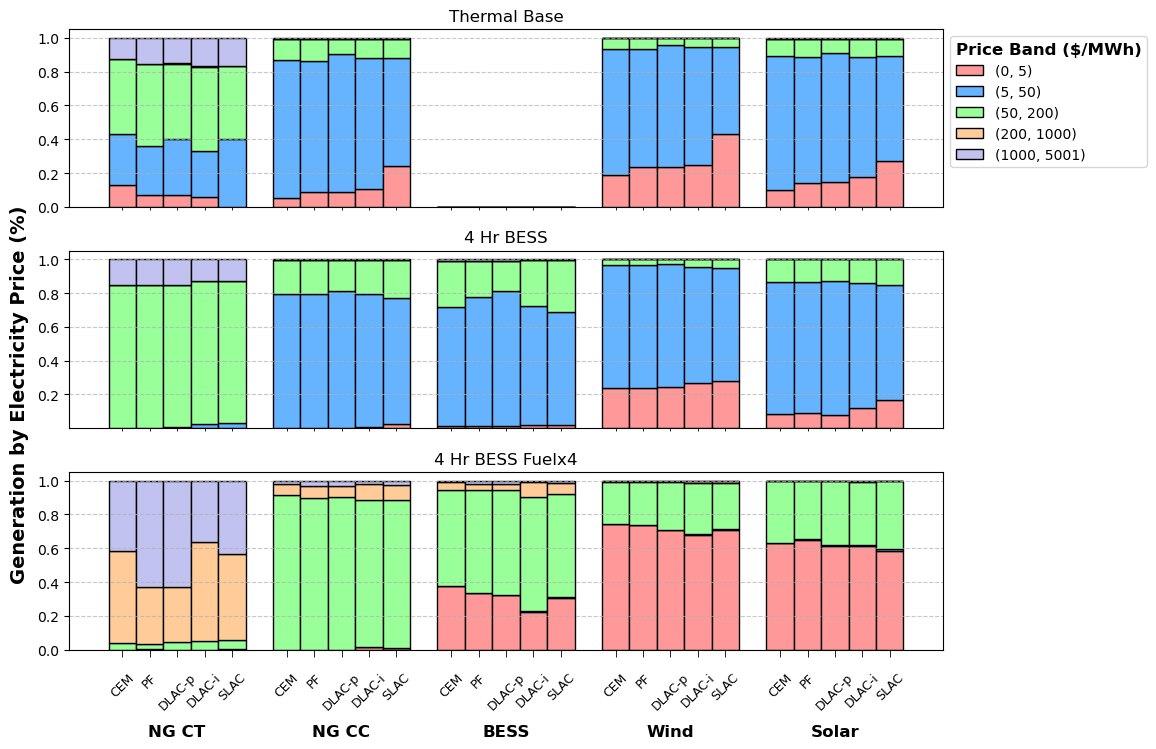

In [15]:
plot_selected_cases_normalized_feature_by_price_band(["Thermal_Base", "4_Hr_BESS","4_Hr_BESS_Fuelx4"], 
                                     generation_by_price_dict, price_band_path,
                                     feature_str='Generation', resource_order = ['NG CT', 'NG CC', 'BESS', 'Wind', 'Solar'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


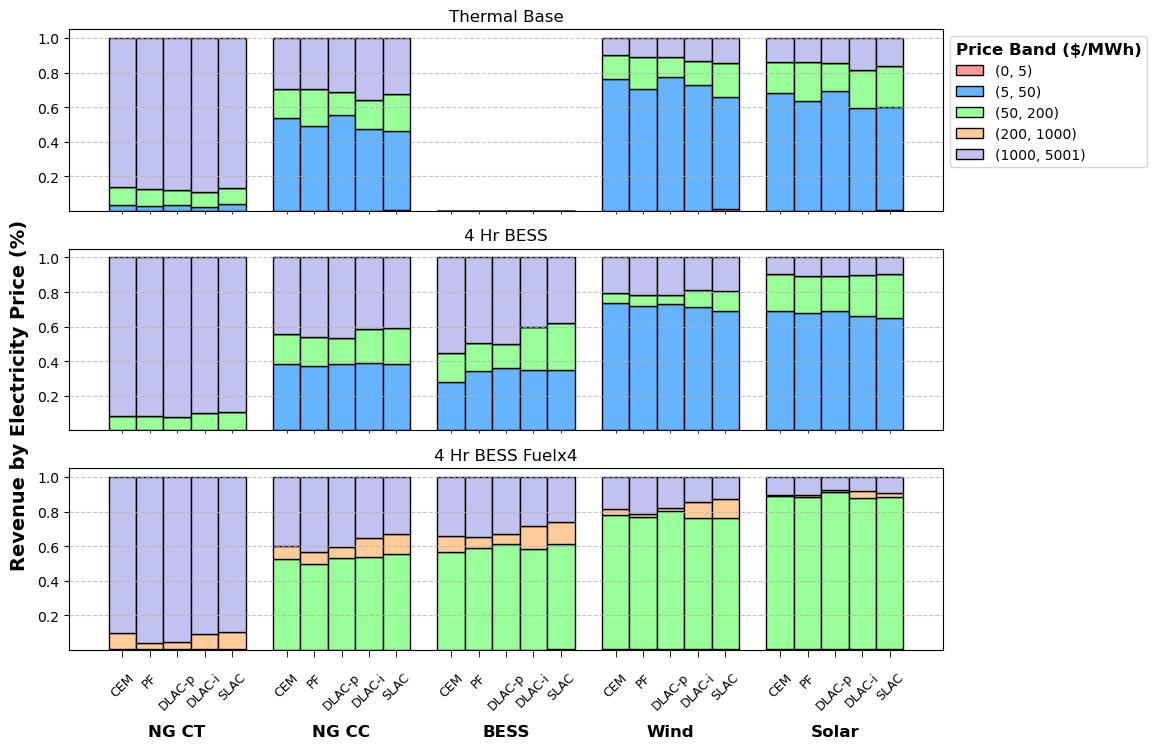

In [16]:
plot_selected_cases_normalized_feature_by_price_band(["Thermal_Base", "4_Hr_BESS","4_Hr_BESS_Fuelx4"], 
                                     revenue_by_price_dict, price_band_path,
                                     feature_str='Revenue', resource_order = ['NG CT', 'NG CC', 'BESS', 'Wind', 'Solar'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


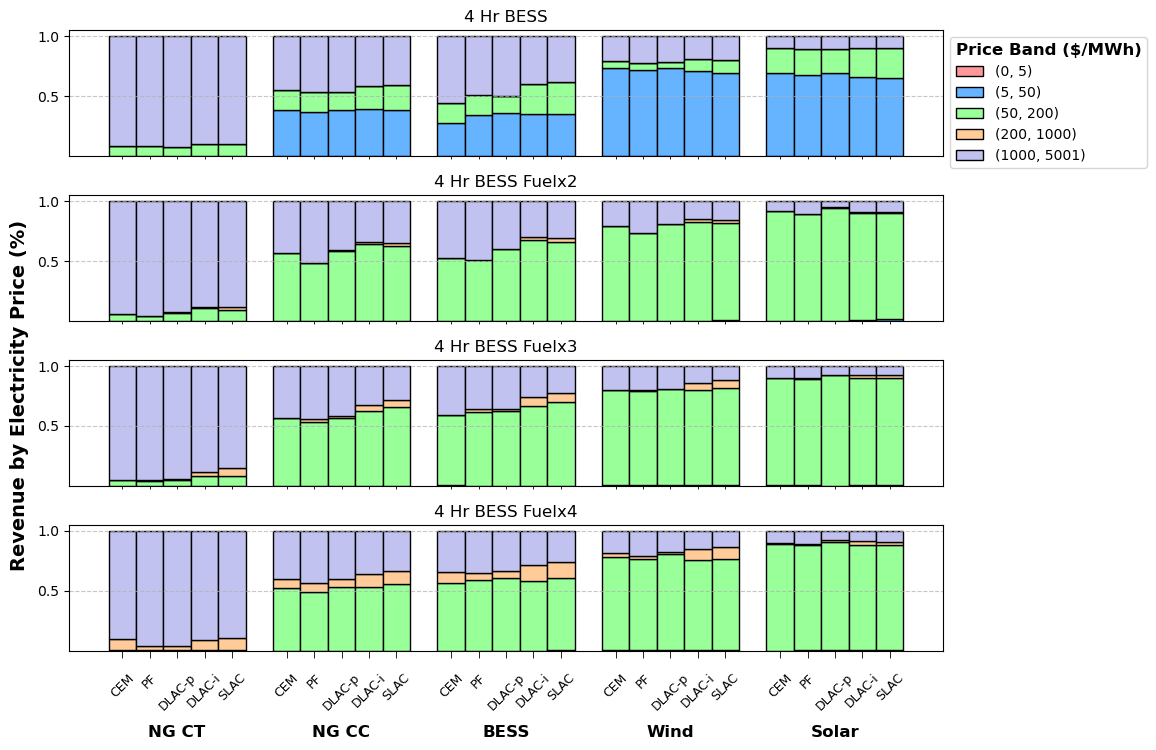

In [17]:
plot_selected_cases_normalized_feature_by_price_band(["4_Hr_BESS","4_Hr_BESS_Fuelx2","4_Hr_BESS_Fuelx3","4_Hr_BESS_Fuelx4"], 
                                     revenue_by_price_dict, price_band_path,
                                    feature_str='Revenue', resource_order = ['NG CT', 'NG CC', 'BESS', 'Wind', 'Solar'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


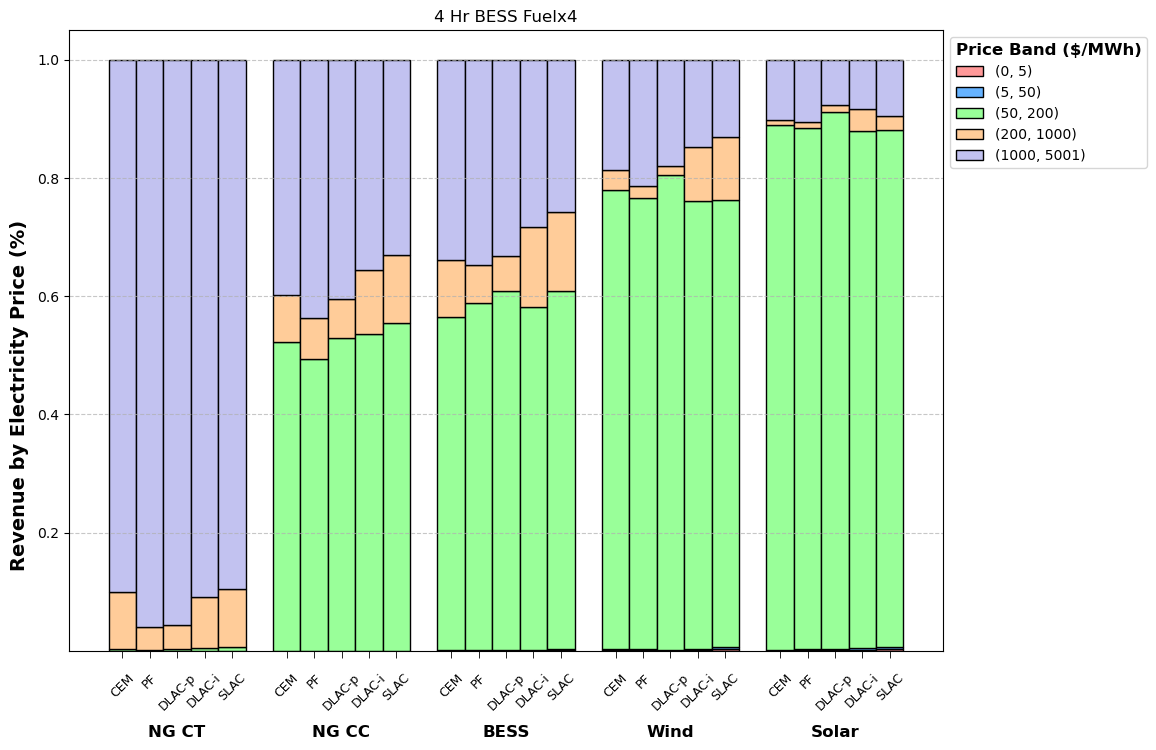

In [18]:
plot_selected_cases_normalized_feature_by_price_band(["4_Hr_BESS_Fuelx4"], 
                                     revenue_by_price_dict, price_band_path,
                                     feature_str='Revenue', resource_order = ['NG CT', 'NG CC', 'BESS', 'Wind', 'Solar'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


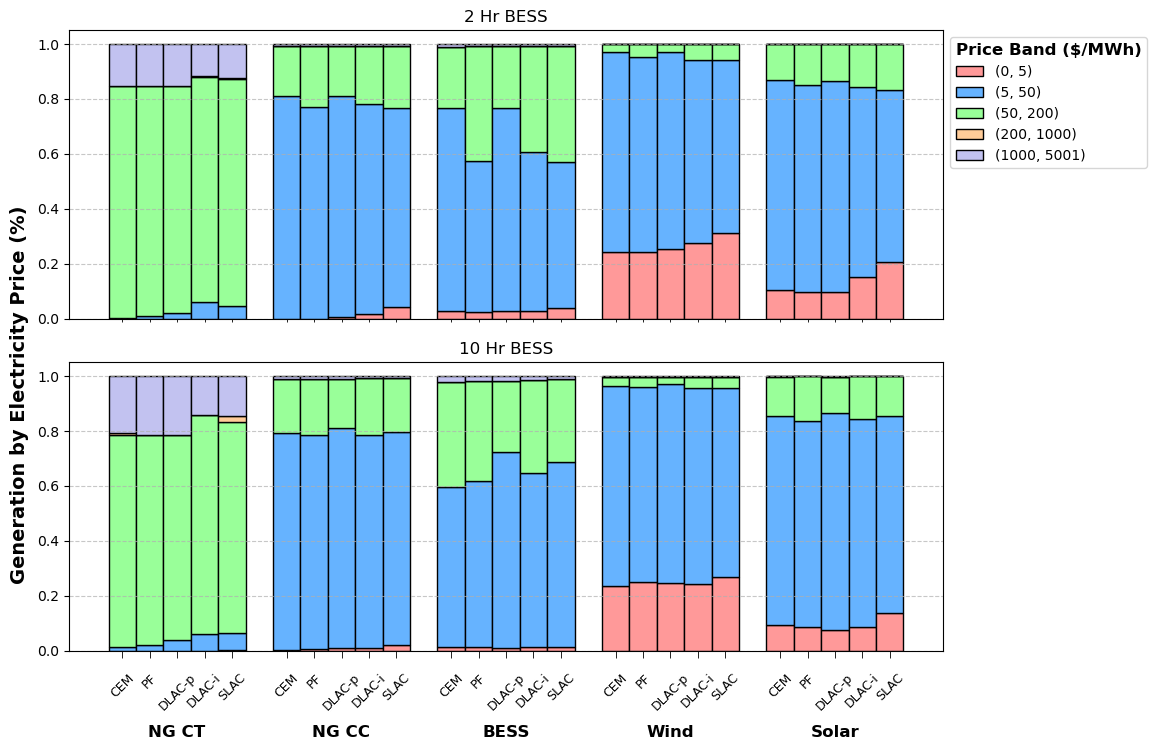

In [19]:
plot_selected_cases_normalized_feature_by_price_band(["2_Hr_BESS", "10_Hr_BESS"], 
                                     generation_by_price_dict, price_band_path,
                                     feature_str='Generation', resource_order = ['NG CT', 'NG CC', 'BESS', 'Wind', 'Solar'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


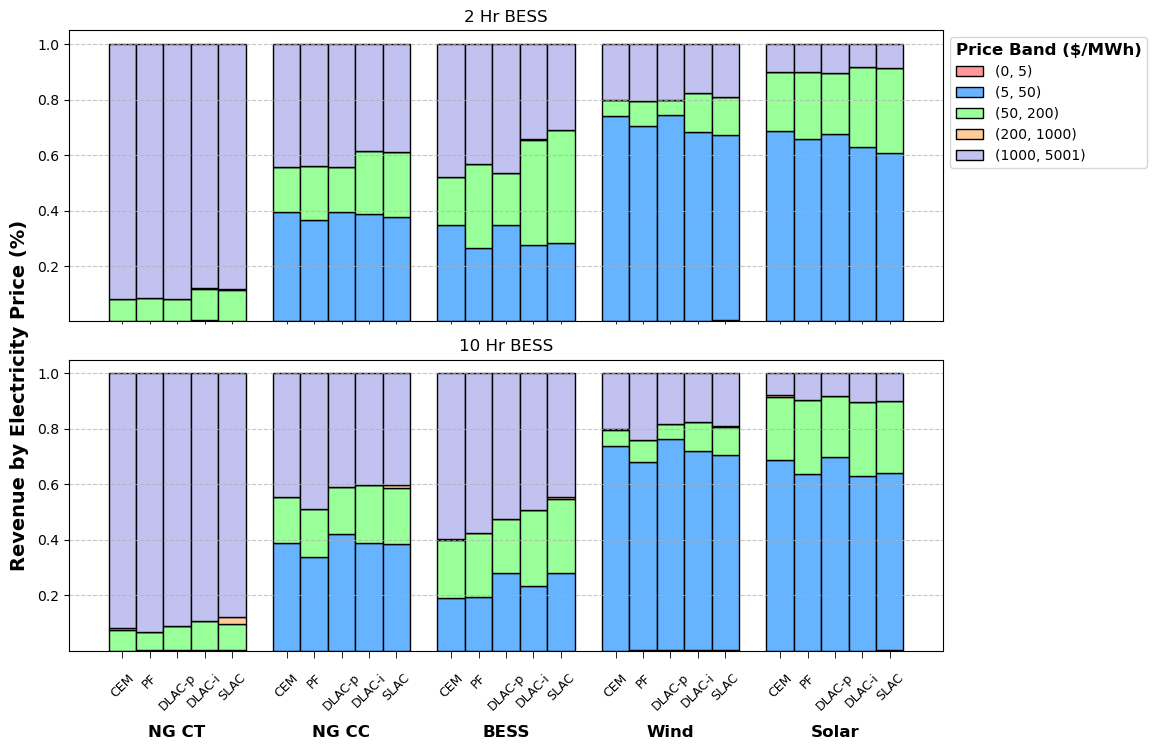

In [20]:
plot_selected_cases_normalized_feature_by_price_band(["2_Hr_BESS", "10_Hr_BESS"], 
                                     revenue_by_price_dict, price_band_path,
                                     feature_str='Revenue', resource_order = ['NG CT', 'NG CC', 'BESS', 'Wind', 'Solar'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


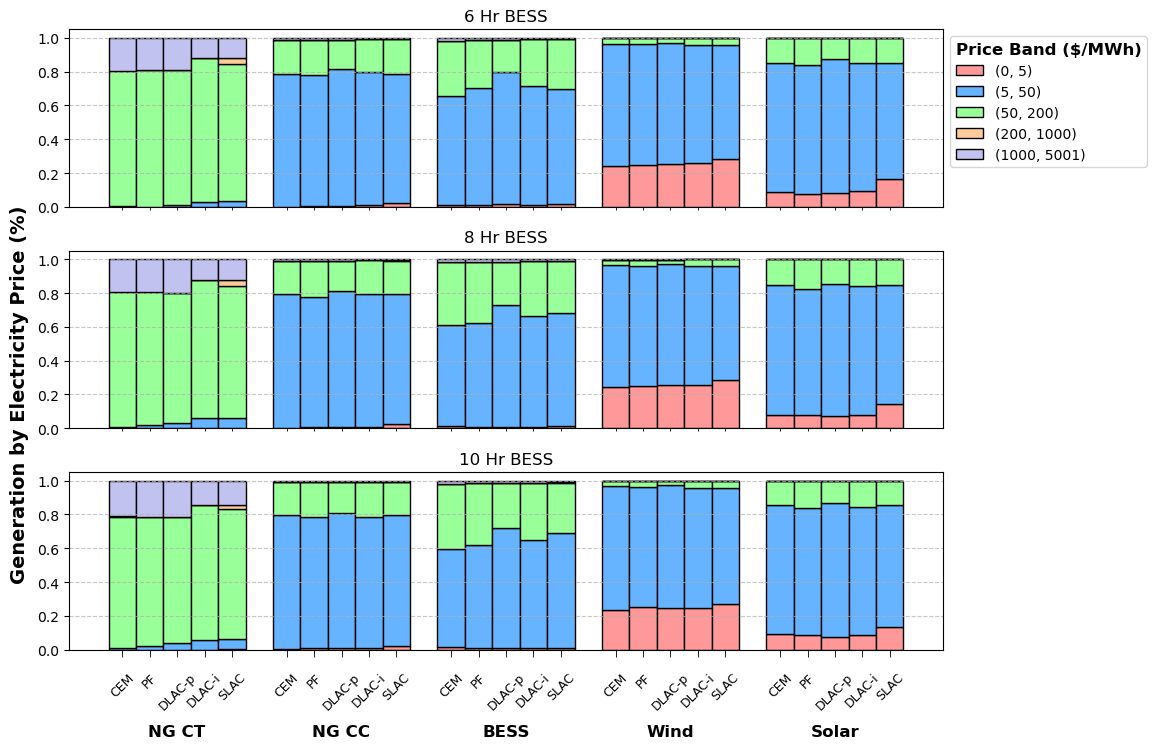

In [21]:
plot_selected_cases_normalized_feature_by_price_band(["6_Hr_BESS", "8_Hr_BESS", "10_Hr_BESS"], 
                                     generation_by_price_dict, price_band_path,
                                     feature_str='Generation', resource_order = ['NG CT', 'NG CC', 'BESS', 'Wind', 'Solar'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


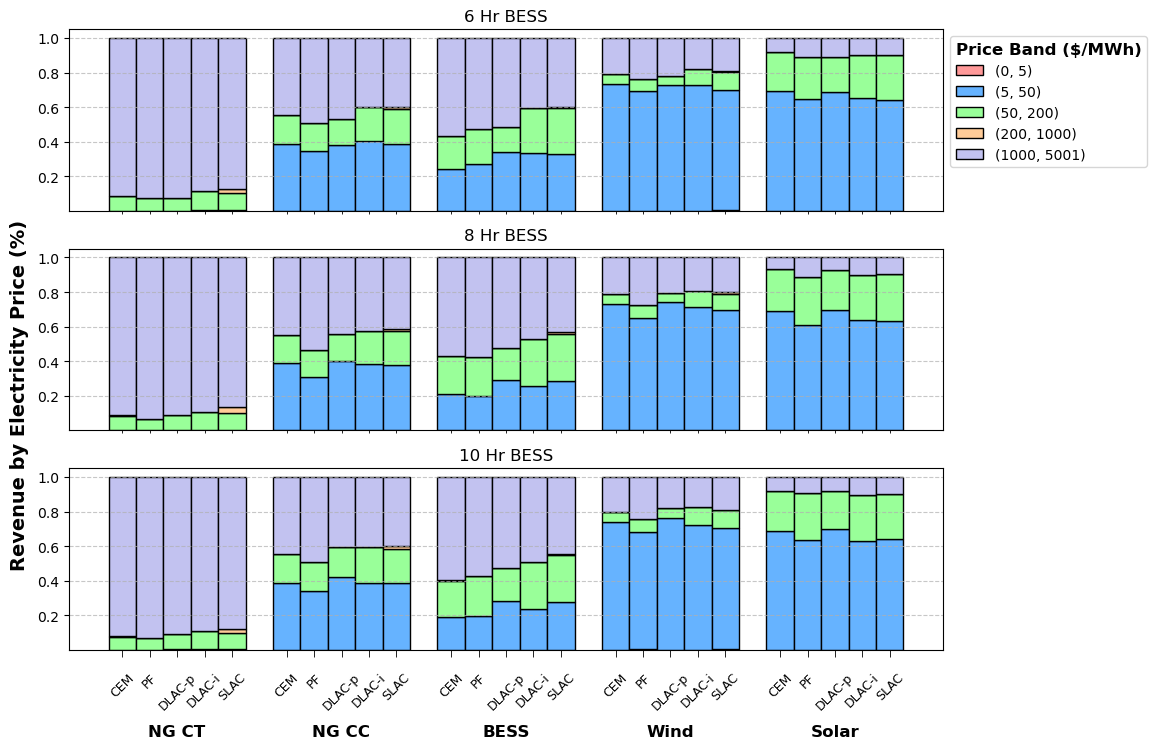

In [22]:
plot_selected_cases_normalized_feature_by_price_band(["6_Hr_BESS", "8_Hr_BESS", "10_Hr_BESS"], 
                                     revenue_by_price_dict, price_band_path,
                                     feature_str='Revenue', resource_order = ['NG CT', 'NG CC', 'BESS', 'Wind', 'Solar'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


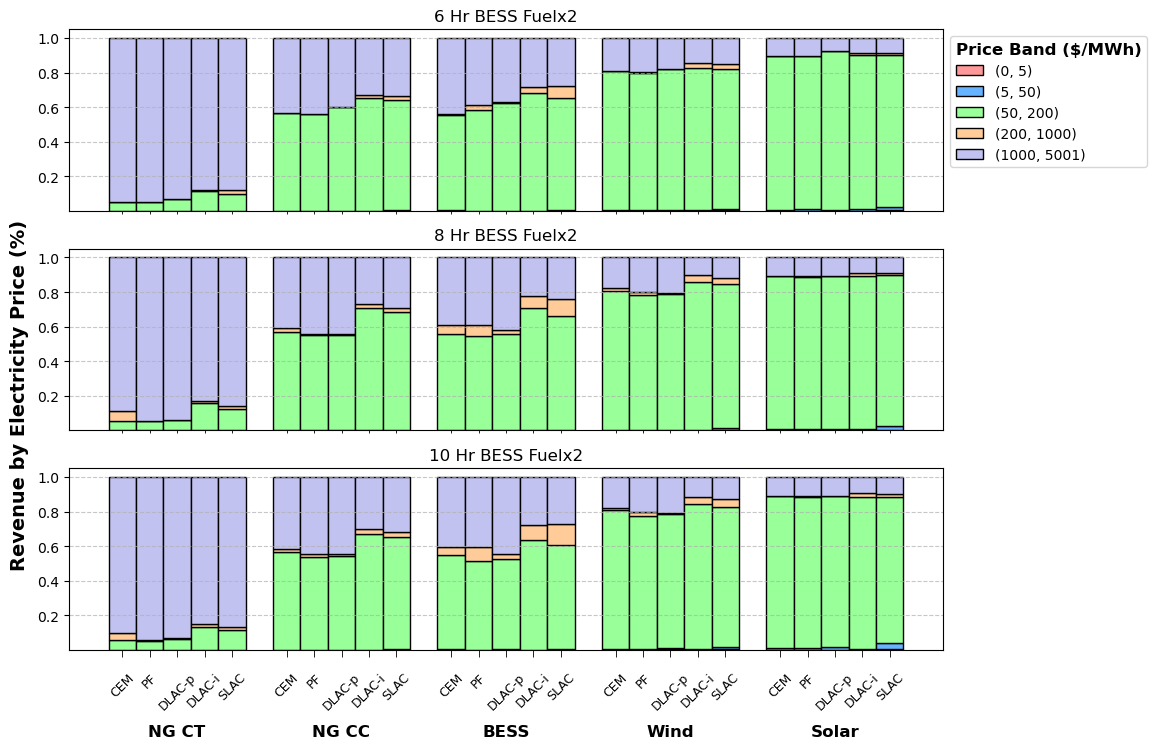

In [23]:
plot_selected_cases_normalized_feature_by_price_band(["6_Hr_BESS_Fuelx2", "8_Hr_BESS_Fuelx2", "10_Hr_BESS_Fuelx2"], 
                                     revenue_by_price_dict, price_band_path,
                                     feature_str='Revenue', resource_order = ['NG CT', 'NG CC', 'BESS', 'Wind', 'Solar'])